In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
    Samplers,
)
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time
import pickle

from ema_workbench.util import utilities
from ema_workbench.analysis import prim, cart

In [2]:
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

# Open Exploration

- No policy (everything 0)
- Latin hypercube of scenarios (10.000 scenarios)
- Result: choose 20 to 50 scenarios

First, the model is initialized, using problem formulation 5.

In [3]:
# initiate model
dike_model, planning_steps = get_model_for_problem_formulation(5)

Then, a reference policy is initialized, in which all policy variables are set to 0.

In [4]:
# set reference policy as all 0's
reference = Policy("0_policy", **{l.name: 0 for l in dike_model.levers})

if we decide to include the timestep:this saves the seperate timesteps to a csv.

In [5]:
# n_scenarios = 10000
#
# # running the model through EMA workbench, using Latin Hypercube Sampling and the reference policy
# with MultiprocessingEvaluator(dike_model, n_processes=-1) as evaluator:
#     results = evaluator.perform_experiments(scenarios=n_scenarios, policies=reference, uncertainty_sampling=Samplers.LHS)
#
# utilities.save_results(results,r'generated_datasets\50ScenariosBaseCase_separate.csv')

[MainProcess/INFO] pool started with 11 workers
[MainProcess/INFO] performing 50 scenarios * 1 policies * 1 model(s) = 50 experiments
100%|██████████████████████████████████████████| 50/50 [00:05<00:00,  9.65it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
[MainProcess/INFO] results saved successfully to C:\Users\beren\Documents\TU_Delft\M_Jaar_1\Q4\Model_based_decision_making\github_map\EPA1361_Model-based_Decision-making\Final Assignment EPA1361\generated_datasets\50ScenariosBaseCase_separate.csv


In [9]:
# test = pd.read_csv(r'generated_datasets\50ScenariosBaseCase_separate.csv', compression='gzip',on_bad_lines='skip').dropna()
# test

,experiments.csv,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model
0,126.0,111.348875,1.5,0.133230,261.725044,1.0,0.577287,269.077980,10.0,0.480473,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0_policy,dikesnet
1,104.0,336.368360,10.0,0.899478,203.087113,10.0,0.136320,314.434932,10.0,0.631970,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0_policy,dikesnet
2,100.0,74.307273,10.0,0.708624,228.887105,1.5,0.500437,212.746074,10.0,0.866909,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0_policy,dikesnet
3,8.0,65.256228,1.0,0.761450,67.749557,1.0,0.936074,227.394598,1.0,0.128171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0_policy,dikesnet
4,13.0,142.257793,1.0,0.613856,92.976188,1.0,0.915484,179.168031,1.5,0.434592,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0_policy,dikesnet
5,56.0,272.007278,10.0,0.922993,196.909703,1.5,0.544760,135.298215,1.0,0.253156,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0_policy,dikesnet
6,117.0,178.056893,1.0,0.738678,251.692605,1.0,0.776795,148.813297,1.0,0.304660,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0_policy,dikesnet
7,28.0,320.191224,1.5,0.527817,290.484986,10.0,0.788140,248.947873,1.5,0.023883,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0_policy,dikesnet
8,83.0,325.379644,1.5,0.972160,53.232680,1.0,0.045938,328.462179,1.0,0.539880,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0_policy,dikesnet
9,34.0,301.868438,1.0,0.599421,283.609618,10.0,0.222694,244.311736,1.0,0.351748,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0_policy,dikesnet


However, this is the one that we will be using: combining the timesteps into a single value. The model is run, and results are saved

In [10]:
n_scenarios = 10_000

# running the model through EMA workbench, using Latin Hypercube Sampling and the reference policy
with MultiprocessingEvaluator(dike_model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=n_scenarios, policies=reference, uncertainty_sampling=Samplers.LHS)

[MainProcess/INFO] pool started with 11 workers
[MainProcess/INFO] performing 50 scenarios * 1 policies * 1 model(s) = 50 experiments
100%|██████████████████████████████████████████| 50/50 [00:05<00:00,  8.84it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [11]:
# as we do not plan on using the timeseries data, we add them up into a single value. This is then saved to a pickle file for later use

df = pd.DataFrame()
for k in outcomes:
    test_list = []
    for i in range(len(experiments)):
        t = outcomes[k][i].sum()
        test_list.append(t)
    df[k]=test_list

with open(r'generated_datasets\open_exploration_base_policy.pkl','wb') as pickle_file:
    pickle.dump(df, pickle_file)

The data is then loaded into a dataframe. The cost of death variables are calculated and added to the data.

In [29]:
outcomes = pd.read_pickle(r'generated_datasets\open_exploration_base_policy.pkl')

,A.1_Expected Annual Damage,A.1_Dike Investment Costs,A.1_Expected Number of Deaths,A.2_Expected Annual Damage,A.2_Dike Investment Costs,A.2_Expected Number of Deaths,A.3_Expected Annual Damage,A.3_Dike Investment Costs,A.3_Expected Number of Deaths,A.4_Expected Annual Damage,A.4_Dike Investment Costs,A.4_Expected Number of Deaths,A.5_Expected Annual Damage,A.5_Dike Investment Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
0,0.000000e+00,0,0.000000,1.246887e+07,0,0.014627,8.825130e+07,0,0.189763,7.476875e+06,0,0.004469,0.000000e+00,0,0.000000,0.0,0.0
1,3.928848e+09,0,1.930736,9.923413e+07,0,0.064237,1.302867e+07,0,0.016647,4.565641e+07,0,0.011372,3.696893e+07,0,0.022832,0.0,0.0
2,2.125978e+07,0,0.018459,1.240516e+07,0,0.014486,1.768876e+09,0,3.534722,0.000000e+00,0,0.000000,1.362992e+08,0,0.137691,0.0,0.0
3,2.315957e+09,0,1.917431,7.432735e+08,0,0.769819,0.000000e+00,0,0.000000,0.000000e+00,0,0.000000,0.000000e+00,0,0.000000,0.0,0.0
4,2.614452e+09,0,1.917667,2.821747e+08,0,0.260900,0.000000e+00,0,0.000000,0.000000e+00,0,0.000000,0.000000e+00,0,0.000000,0.0,0.0
5,0.000000e+00,0,0.000000,4.605499e+07,0,0.052439,1.033031e+07,0,0.022294,1.144022e+08,0,0.059004,0.000000e+00,0,0.000000,0.0,0.0
6,2.146744e+09,0,1.723066,0.000000e+00,0,0.000000,0.000000e+00,0,0.000000,0.000000e+00,0,0.000000,0.000000e+00,0,0.000000,0.0,0.0
7,6.594224e+07,0,0.038641,2.064908e+08,0,0.154983,9.199486e+08,0,1.295054,0.000000e+00,0,0.000000,0.000000e+00,0,0.000000,0.0,0.0
8,0.000000e+00,0,0.000000,2.164205e+08,0,0.217170,0.000000e+00,0,0.000000,1.578302e+08,0,0.070572,0.000000e+00,0,0.000000,0.0,0.0
9,0.000000e+00,0,0.000000,2.291057e+08,0,0.196572,0.000000e+00,0,0.000000,1.455871e+07,0,0.006240,0.000000e+00,0,0.000000,0.0,0.0


In [13]:
# calculate the cost of death so every column has the same unit (€)
outcomes["A.1_Deaths_Cost"]=outcomes["A.1_Expected Number of Deaths"]*2_700_000
outcomes["A.2_Deaths_Cost"]=outcomes["A.2_Expected Number of Deaths"]*2_700_000
outcomes["A.3_Deaths_Cost"]=outcomes["A.3_Expected Number of Deaths"]*2_700_000
outcomes["A.4_Deaths_Cost"]=outcomes["A.4_Expected Number of Deaths"]*2_700_000
outcomes["A.5_Deaths_Cost"]=outcomes["A.5_Expected Number of Deaths"]*2_700_000

to_drop = ["A.1_Expected Number of Deaths","A.2_Expected Number of Deaths","A.3_Expected Number of Deaths","A.4_Expected Number of Deaths","A.5_Expected Number of Deaths"]

outcomes.drop(to_drop, axis=1, inplace=True)
outcomes['total_cost[€]']= outcomes.sum(axis=1)

In [14]:
#input variables and output combined into a single dataframe
results = experiments.join(outcomes)
results.drop(columns=['policy','model','scenario'], inplace=True)

In [31]:
results


,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.5_Expected Annual Damage,A.5_Dike Investment Costs,RfR Total Costs,Expected Evacuation Costs,A.1_Deaths_Cost,A.2_Deaths_Cost,A.3_Deaths_Cost,A.4_Deaths_Cost,A.5_Deaths_Cost,total_cost[€]
0,0,326.392559,1.0,0.954250,275.167917,1.0,0.886839,330.034564,10.0,0.563028,...,0.000000e+00,0,0.0,0.0,0.000000e+00,3.949417e+04,5.123598e+05,12065.478178,0.000000e+00,1.087610e+08
1,68,175.422299,1.0,0.276320,301.790629,1.5,0.148743,156.716040,1.5,0.323379,...,3.696893e+07,0,0.0,0.0,5.212988e+06,1.734398e+05,4.494787e+04,30703.842809,6.164774e+04,4.129260e+09
2,37,39.732071,10.0,0.713907,54.901169,1.0,0.909497,140.603640,1.0,0.145480,...,1.362992e+08,0,0.0,0.0,4.983976e+04,3.911209e+04,9.543749e+06,0.000000,3.717667e+05,1.948845e+09
3,12,75.140589,10.0,0.037074,280.049692,1.0,0.021368,210.545805,10.0,0.589088,...,0.000000e+00,0,0.0,0.0,5.177063e+06,2.078512e+06,0.000000e+00,0.000000,0.000000e+00,3.066486e+09
4,62,139.511183,1.0,0.051726,91.160904,1.0,0.054867,71.035261,1.5,0.665164,...,0.000000e+00,0,0.0,0.0,5.177700e+06,7.044308e+05,0.000000e+00,0.000000,0.000000e+00,2.902509e+09
5,101,63.739053,1.0,0.885982,104.198768,10.0,0.581198,170.006172,1.0,0.760105,...,0.000000e+00,0,0.0,0.0,0.000000e+00,1.415861e+05,6.019357e+04,159311.236778,0.000000e+00,1.711486e+08
6,59,270.357729,1.5,0.335601,338.739166,1.5,0.735919,96.377914,10.0,0.649009,...,0.000000e+00,0,0.0,0.0,4.652278e+06,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,2.151396e+09
7,112,57.186460,1.0,0.670472,219.049102,1.5,0.350771,222.022362,1.0,0.295340,...,0.000000e+00,0,0.0,0.0,1.043311e+05,4.184546e+05,3.496646e+06,0.000000,0.000000e+00,1.196401e+09
8,117,215.128381,1.5,0.901174,86.298566,1.0,0.278838,119.209639,1.0,0.694711,...,0.000000e+00,0,0.0,0.0,0.000000e+00,5.863580e+05,0.000000e+00,190543.779417,0.000000e+00,3.750277e+08
9,102,50.333157,1.5,0.778688,177.521340,1.0,0.257576,53.807223,10.0,0.873681,...,0.000000e+00,0,0.0,0.0,0.000000e+00,5.307437e+05,0.000000e+00,16848.114732,0.000000e+00,2.442120e+08


In [16]:
total_values = pd.DataFrame()
total_values['Expected Annual Damage'] = results['A.1_Expected Annual Damage'] + \
                                         results['A.2_Expected Annual Damage'] + \
                                         results['A.3_Expected Annual Damage'] + \
                                         results['A.4_Expected Annual Damage'] + \
                                         results['A.5_Expected Annual Damage']

total_values['Dike Investment Costs'] = results['A.1_Dike Investment Costs'] + \
                                        results['A.2_Dike Investment Costs'] + \
                                        results['A.3_Dike Investment Costs'] + \
                                        results['A.4_Dike Investment Costs'] + \
                                        results['A.5_Dike Investment Costs']

total_values['Deaths_Cost'] = results['A.1_Deaths_Cost'] + \
                              results['A.2_Deaths_Cost'] + \
                              results['A.3_Deaths_Cost'] + \
                              results['A.4_Deaths_Cost'] + \
                              results['A.5_Deaths_Cost']

# Visualizations / conclusions?

Finding the worst case scenarios top 20, difined by highest total costs

In [28]:
n_scenarios_of_interest = 20

results_of_interest = results.sort_values(by='total_cost[€]', ascending=False).head(n_scenarios_of_interest)

with open(r'generated_datasets\open_exploration_base_policy_worst_scenarios.pkl','wb') as pickle_file:
    pickle.dump(results_of_interest, pickle_file)

### Scenario Discovery
- Boxplots
- PRIM
- Scatterplots
- CART-tree

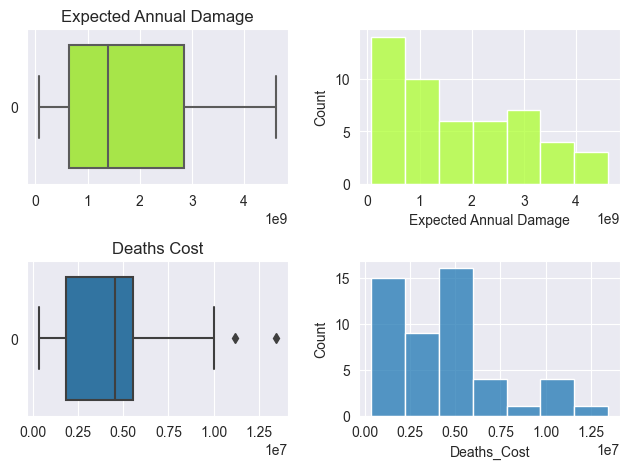

In [17]:
fig, axes = plt.subplots(2,2)

# Expected Annual Damage boxplot
sns.boxplot(
    ax=axes[0,0],
    data=total_values['Expected Annual Damage'],
    orient='h',
    color='greenyellow',
).set(title='Expected Annual Damage')

# Deaths_Cost boxplot
sns.boxplot(
    ax=axes[1,0],
    data=total_values['Deaths_Cost'],
    orient='h',
).set(title='Deaths Cost')

# Expected Annual Damage histogram
sns.histplot(
    ax=axes[0,1],
    data=total_values['Expected Annual Damage'],
    bins=7,
    color='greenyellow',
)

# Deaths_Cost histogram
sns.histplot(
    ax=axes[1,1],
    data=total_values['Deaths_Cost'],
    bins=7,
)

plt.tight_layout()

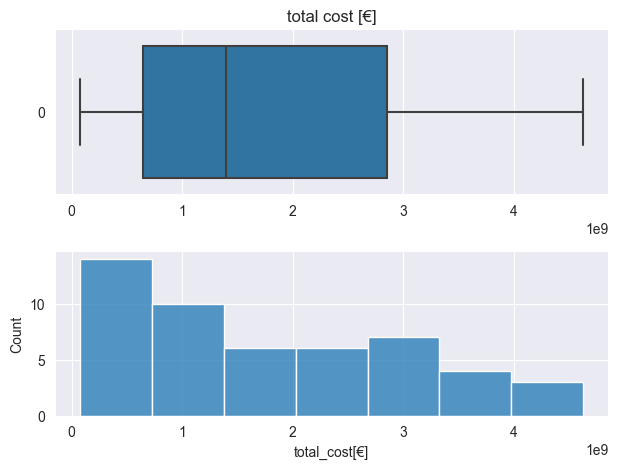

In [18]:
fig, axes = plt.subplots(2)

sns.boxplot(
    ax=axes[0],
    data=results['total_cost[€]'],
    orient='h',
).set(title='total cost [€]')

sns.histplot(
    ax=axes[1],
    data=results['total_cost[€]'],
    bins=7,
)

plt.tight_layout()

Eventueel nog plots per dikering

### DEATH ANALYSIS, SAME CAN BE DONE FOR OTHER VARIABLES

In [19]:
x = results.iloc[:,:19]  # Only take the uncertainties

y_death_cost = total_values['Deaths_Cost'].values
y_death_cost = y_death_cost > np.percentile(y_death_cost, 75)

[MainProcess/INFO] 50 points remaining, containing 13 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.2, coverage: 0.7692307692307693, density: 1.0 restricted_dimensions: 6


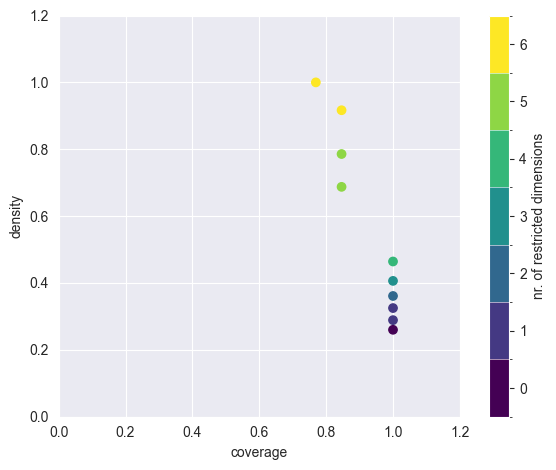

In [20]:
prim_alg = prim.Prim(x,
                     y_death_cost,
                     threshold=0.65,
                     peel_alpha=0.10,) # deze variabelen nog tweaken
box = prim_alg.find_box()

box.show_tradeoff()
plt.tight_layout()

coverage    0.769231
density     1.000000
id          9.000000
mass        0.200000
mean        1.000000
res_dim     6.000000
Name: 9, dtype: float64

                 box 9                                 
                   min          max  qp value  qp value
A.1_Bmax     34.438859   212.551607       NaN  0.023590
A.3_pfail      0.01337     0.851234       NaN  0.161506
A.3_Bmax     33.169637   310.610935       NaN  0.385543
A.1_pfail     0.006351     0.893578       NaN  1.000000
A.4_Brate  {10.0, 1.0}  {10.0, 1.0}  0.017342       NaN
A.4_pfail     0.326489      0.99438  0.161506       NaN



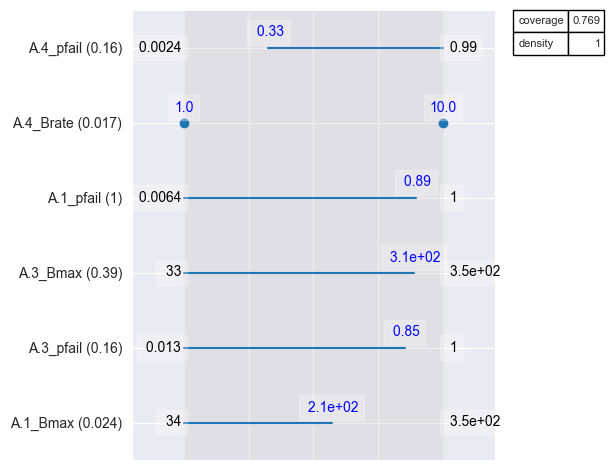

In [21]:
box.inspect()
box.inspect(style='graph')
plt.tight_layout()

C:\Users\beren\Documents\TU_Delft\M_Jaar_1\Q4\Model_based_decision_making\mbd_venv\Lib\site-packages\ema_workbench\analysis\scenario_discovery_util.py:413: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)


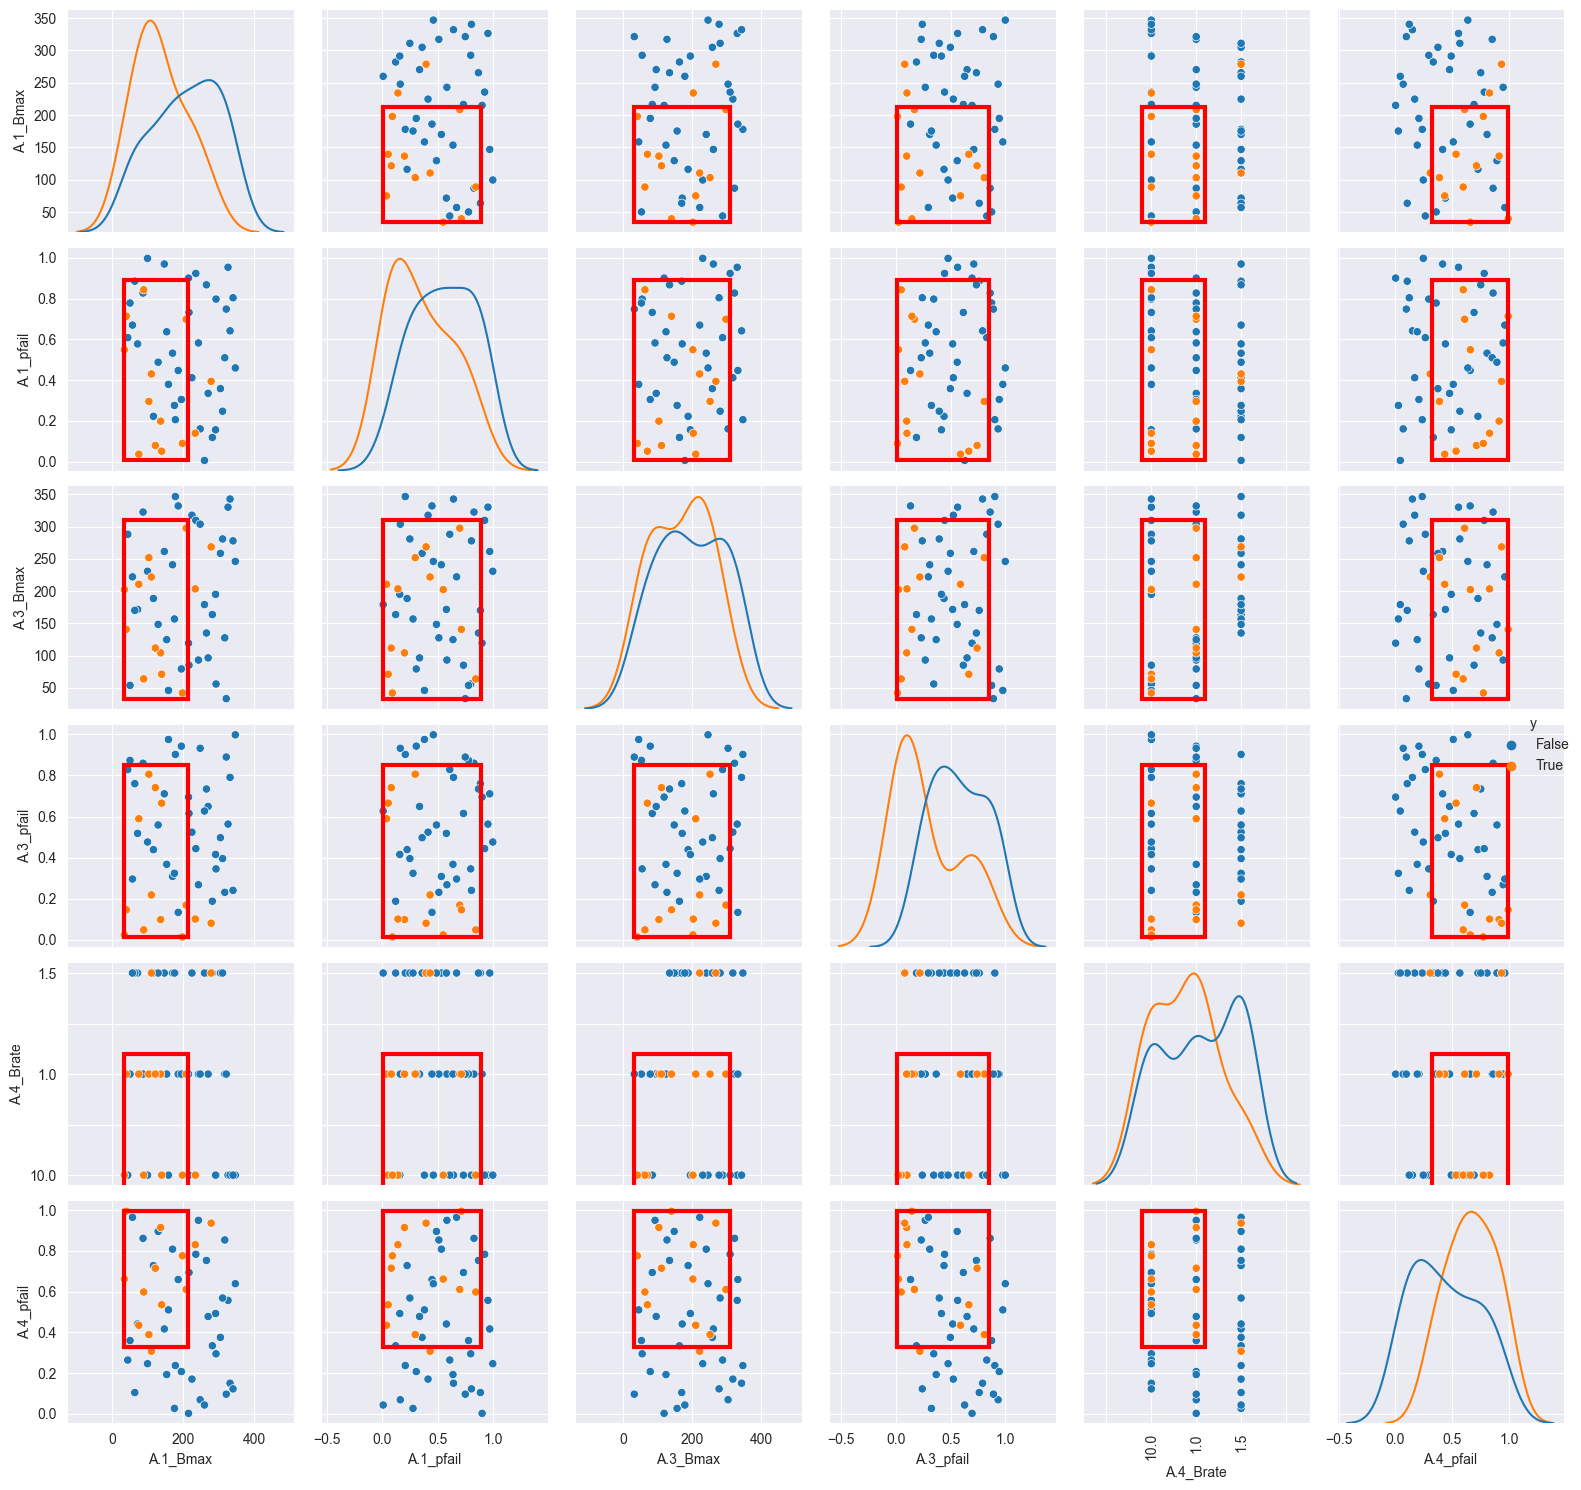

In [22]:
box.select(-1)
box.show_pairs_scatter()
fig = plt.gcf()
plt.tight_layout()

### CART

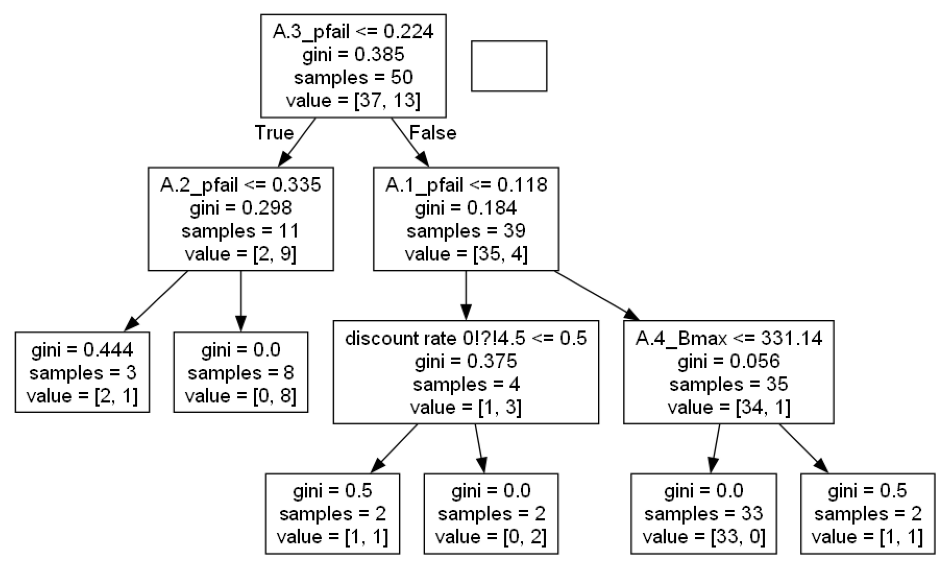

In [23]:
cart_plot = cart.CART(x, y_death_cost, 0.05)
cart_plot.build_tree()

# Make sure to have GraphViz installed for the tree to show up (https://www.graphviz.org/download/)
fig = cart_plot.show_tree()
fig.set_size_inches(12, 12)
plt.show()